# Path Control with Visibility Graph - Rectangular Obstacles

Questo notebook implementa un sistema di controllo di percorso per un robot mobile 2D utilizzando il **Visibility Graph** per la pianificazione del percorso in ambienti con ostacoli rettangolari.

## Funzionalità:

1. **Ambiente con Ostacoli**: Definisce ostacoli rettangolari nell'ambiente
2. **Visibility Graph**: Utilizza l'algoritmo visibility graph per calcolare il percorso ottimale
3. **Path Following**: Il robot segue il percorso calcolato utilizzando controlli PID
4. **Visualizzazione**: Mostra l'ambiente, gli ostacoli e il percorso pianificato

## Algoritmo:

1. **Setup Ambiente**: Crea ostacoli rettangolari nell'ambiente di lavoro
2. **Pianificazione**: Il visibility graph calcola il percorso più breve evitando gli ostacoli
3. **Controllo**: Il robot segue i waypoints utilizzando controlli di velocità PID
4. **Monitoraggio**: Traccia velocità, posizione e performance del sistema

## Output:

- Grafici delle velocità lineari e angolari
- Traiettoria del robot nell'ambiente
- Visualizzazione dell'ambiente con ostacoli e percorso pianificato

=== SETTING UP ENVIRONMENT WITH OBSTACLES ===
Created 5 rectangular obstacles:
  Obstacle 1: vertices = [(0.6, 0.3), (1.0, 0.3), (1.0, 0.7), (0.6, 0.7)]
  Obstacle 2: vertices = [(0.2, 0.2), (0.30000000000000004, 0.2), (0.30000000000000004, 0.4), (0.2, 0.4)]
  Obstacle 3: vertices = [(0.2, 0.9), (0.8, 0.9), (0.8, 1.1), (0.2, 1.1)]
  Obstacle 4: vertices = [(1.2, 1.1), (1.6, 1.1), (1.6, 1.4000000000000001), (1.2, 1.4000000000000001)]
  Obstacle 5: vertices = [(1.0, 0.8), (1.1, 0.8), (1.1, 0.9), (1.0, 0.9)]

=== INITIALIZING VISIBILITY GRAPH PLANNER ===
Start position: (0.0, 0.0)
Goal position: (1.8, 1.5)

=== PLANNING OPTIMAL PATH ===
✓ Path found with total distance: 2.554
Optimal path waypoints:
  1: (0.000, 0.000)
  2: (1.050, 0.250)
  3: (1.650, 1.050)
  4: (1.800, 1.500)

=== VISUALIZING ENVIRONMENT ===


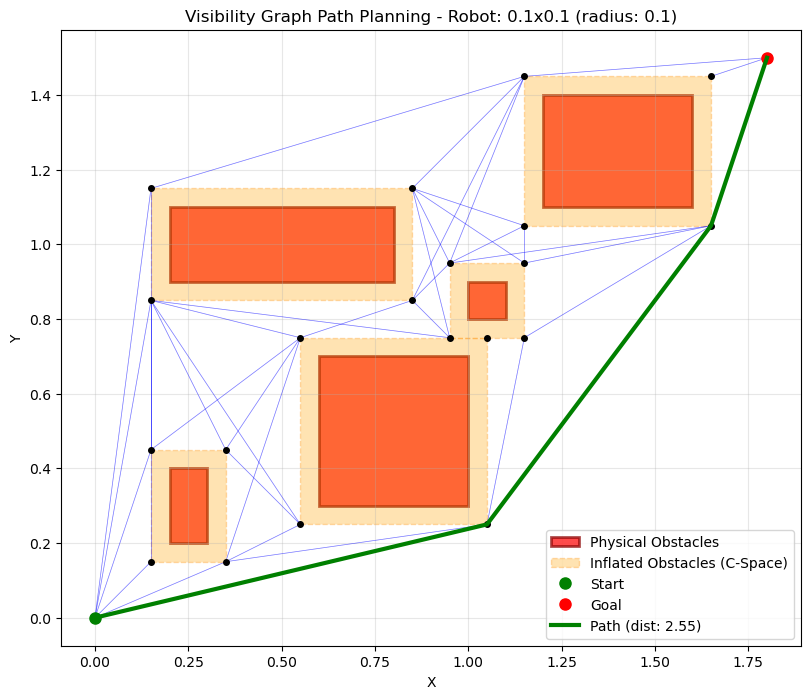


=== STARTING SIMULATION ===
Initial robot pose: (0, 0, 0)
Following 3 waypoints
✓ Path completed successfully at t=13.68

=== SIMULATION RESULTS ===
Final robot pose: (1.7978832740588957, 1.4907533923259977, 1.3294439511278195)
Target goal was: (1.8, 1.5)
Goal error: 0.009 meters
Simulation completed at t=13.68 seconds

=== PLOTTING RESULTS ===


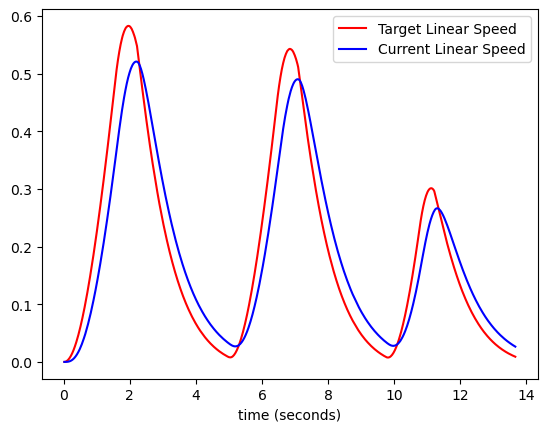

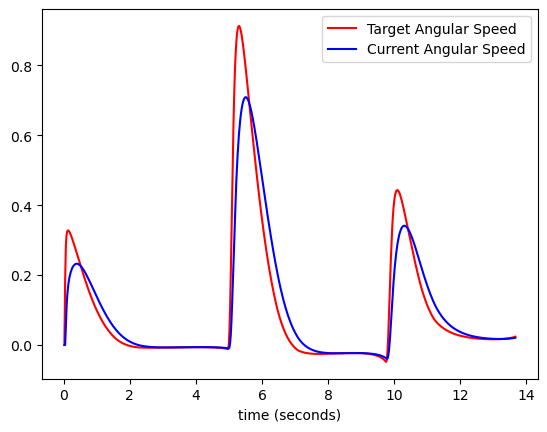

Creating enhanced trajectory plot with obstacles...


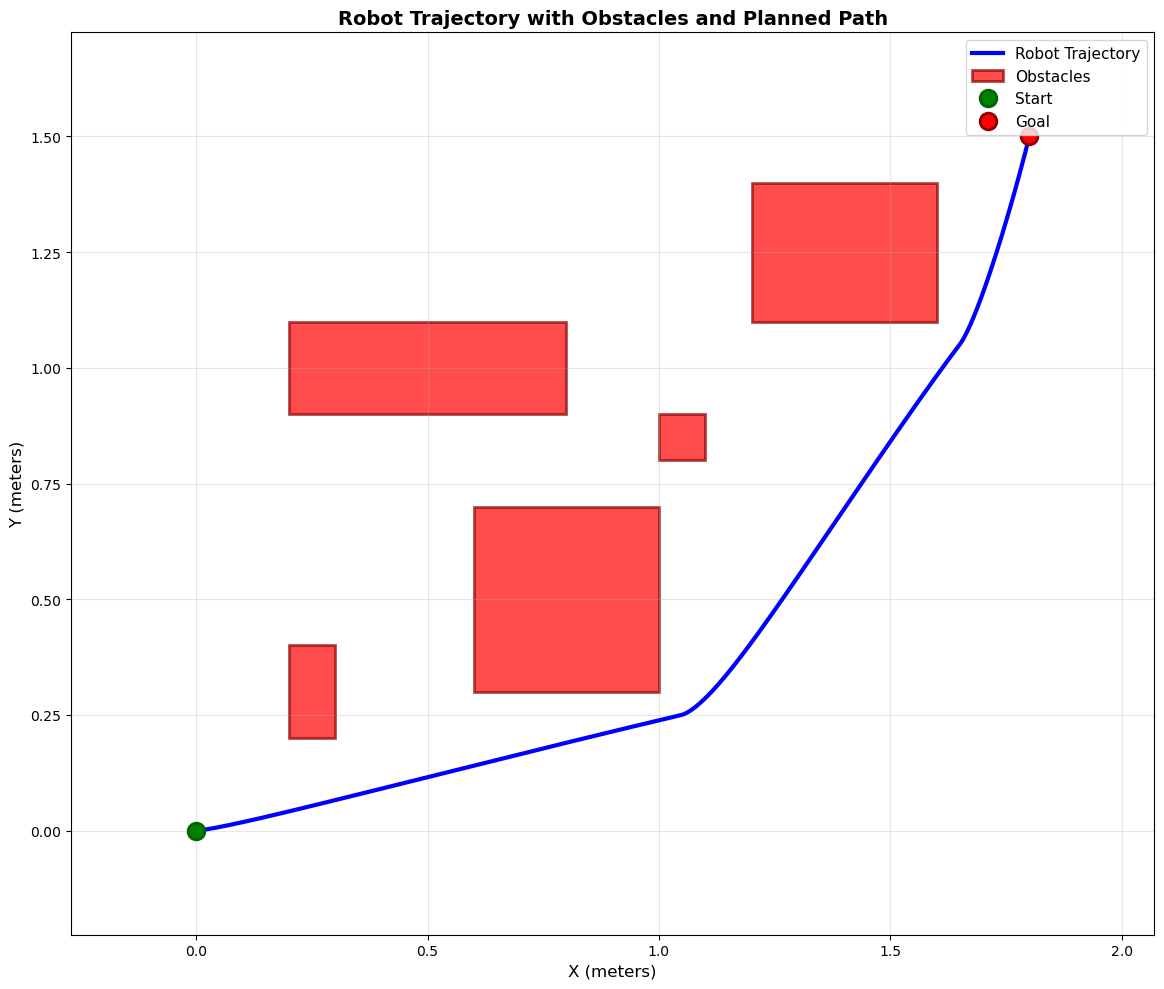

In [1]:
import sys
sys.path.append("../")

from lib.data.dataplot import *
from lib.system.cart import *
from lib.system.controllers import *
from lib.system.trajectory import *
from lib.system.polar import *
from lib.dds.dds import *
from lib.utils.time import *
from lib.path_planner.visibility_graph import VisibilityGraph
from lib.utils.shape import create_rectangular_obstacle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math

def safe_normalize_angle(a):
    if abs(a) > 1e6:
        print(f"Warning: Very large angle detected: {a}. Resetting to 0.")
        return 0.0
    
    a = a % (2 * math.pi)
    if a > math.pi:
        a -= 2 * math.pi
    return a

class SpeedControl2D:
    
    def __init__(self, _lin_params, _rot_params):
        self.linear_controller = PID_Controller(*_lin_params)
        self.rotation_controller = PID_Controller(*_rot_params)
        self.v_target = 0
        self.w_target = 0
    
    def set_v_target(self, v):
        self.v_target = v
        
    def set_w_target(self, w):
        self.w_target = w
        
    def set_targets(self, v, w):
        self.v_target = v
        self.w_target = w
        
    def evaluate(self, delta_t, v_current, w_current):
        v_error = self.v_target - v_current
        f_out = self.linear_controller.evaluate(delta_t, v_error)
        
        w_error = self.w_target - w_current
        t_out = self.rotation_controller.evaluate(delta_t, w_error)
        
        return (f_out, t_out)

# Data plotters
vdp = DataPlotter()
vdp.set_x("time (seconds)")
vdp.add_y("target_speed", "Target Linear Speed")
vdp.add_y("current_speed", "Current Linear Speed")

wdp = DataPlotter()
wdp.set_x("time (seconds)")
wdp.add_y("target_speed", "Target Angular Speed")
wdp.add_y("current_speed", "Current Angular Speed")

tdp = DataPlotter()
tdp.set_x("x")
tdp.add_y("y","y")

trajectory_x = []
trajectory_y = []

# Create obstacles
print("=== SETTING UP ENVIRONMENT WITH OBSTACLES ===")
obstacles = [
    create_rectangular_obstacle(0.6, 0.3, 0.4, 0.4),
    create_rectangular_obstacle(0.2, 0.2, 0.1, 0.2),
    create_rectangular_obstacle(0.2, 0.9, 0.6, 0.2),
    create_rectangular_obstacle(1.2, 1.1, 0.4, 0.3),
    create_rectangular_obstacle(1.0, 0.8, 0.1, 0.1),
]

print(f"Created {len(obstacles)} rectangular obstacles:")
for i, obstacle in enumerate(obstacles):
    vertices = [(v.x, v.y) for v in obstacle.vertices]
    print(f"  Obstacle {i+1}: vertices = {vertices}")

# Initialize planner
print("\n=== INITIALIZING VISIBILITY GRAPH PLANNER ===")
planner = VisibilityGraph(obstacles, 0.1, 0.1)

start_pos = (0.0, 0.0)
goal_pos = (1.8, 1.5)

print(f"Start position: {start_pos}")
print(f"Goal position: {goal_pos}")

# Plan path
print("\n=== PLANNING OPTIMAL PATH ===")
(path_waypoints, total_distance) = planner.plan_path(start_pos, goal_pos)

if path_waypoints:
    print(f"✓ Path found with total distance: {total_distance:.3f}")
    print("Optimal path waypoints:")
    for i, point in enumerate(path_waypoints):
        print(f"  {i+1}: ({point[0]:.3f}, {point[1]:.3f})")
else:
    print("✗ No path found! Check if start/goal are inside obstacles.")
    sys.exit(1)

# Visualize environment
print("\n=== VISUALIZING ENVIRONMENT ===")
planner.visualize_graph(start_pos, goal_pos)

# Initialize robot and controllers
cart2d = Cart2D(1.0, 0.3, 0.9, 0.8)
speed_ctrl = SpeedControl2D([4.0, 2.0, 0.0, 1], [0.5, 4.0, 0.0, 0.7])
polar_position = Polar2DController(0.9, 0.8, 1.5, 3.0)

# Setup path following
path = Path2D(1.0, 0.6, 1.0, 0.01)
pose = cart2d.get_pose()
path.set_path(path_waypoints)
path.start((pose[0], pose[1]))

dds = DDS()
dds.start()

dds.subscribe(['tick'])

print(f"\n=== STARTING SIMULATION ===")
print(f"Initial robot pose: {pose}")
print(f"Following {len(path_waypoints)} waypoints")


t = Time()
t.start()

while t.get() < 30:
    
    t.sleep(0.02)
    delta_t = t.elapsed()

    pose = cart2d.get_pose()
    target = path.evaluate(delta_t, pose)
    
    if target is None:
        print(f"✓ Path completed successfully at t={t.get():.2f}")
        t.sleep(20)
        break
        
    (x_target, y_target) = target

    try:
        (v_target, w_target) = polar_position.evaluate(delta_t, x_target, y_target, pose)
        v_et = max(-2.0, min(2.0, v_target))
        w_et = max(-3.0, min(3.0, w_target))
        
    except Exception as e:
        print(f"Error in polar_position.evaluate: {e}")
        print(f"x_target={x_target}, y_target={y_target}, pose={pose}")
        break
    
    (v, w) = cart2d.get_speed()
    speed_ctrl.set_targets(v_target, w_target)
    (force, torque) = speed_ctrl.evaluate(delta_t, v, w)
    
    force = max(-10.0, min(10.0, force))
    torque = max(-5.0, min(5.0, torque))
    
    cart2d.evaluate(delta_t, force, torque)

    dds.publish('X', pose[0], DDS.DDS_TYPE_FLOAT)
    dds.publish('Y', pose[1], DDS.DDS_TYPE_FLOAT)
    dds.publish('Theta', pose[2], DDS.DDS_TYPE_FLOAT)

    vdp.append_x(t.get())
    vdp.append_y("current_speed", v)
    vdp.append_y("target_speed", speed_ctrl.v_target)
    
    wdp.append_x(t.get())
    wdp.append_y("current_speed", w)
    wdp.append_y("target_speed", speed_ctrl.w_target)
    
    tdp.append_x(pose[0])
    tdp.append_y("y", pose[1])
    
    trajectory_x.append(pose[0])
    trajectory_y.append(pose[1])

print(f"\n=== SIMULATION RESULTS ===")
print(f"Final robot pose: {cart2d.get_pose()}")
print(f"Target goal was: {goal_pos}")
final_pose = cart2d.get_pose()
goal_error = math.sqrt((final_pose[0] - goal_pos[0])**2 + (final_pose[1] - goal_pos[1])**2)
print(f"Goal error: {goal_error:.3f} meters")
print(f"Simulation completed at t={t.get():.2f} seconds")

# Plot results
print("\n=== PLOTTING RESULTS ===")
vdp.plot()
wdp.plot()

# Enhanced trajectory plot with obstacles
print("Creating enhanced trajectory plot with obstacles...")

fig, ax = plt.subplots(figsize=(12, 10))

ax.plot(trajectory_x, trajectory_y, 'b-', linewidth=3, label='Robot Trajectory', zorder=3)

for i, obstacle in enumerate(obstacles):
    vertices = [(v.x, v.y) for v in obstacle.vertices]
    label = 'Obstacles' if i == 0 else None
    polygon = patches.Polygon(vertices, closed=True, facecolor='red', alpha=0.7, 
                            edgecolor='darkred', linewidth=2, label=label)
    ax.add_patch(polygon)

ax.plot(start_pos[0], start_pos[1], 'go', markersize=12, label='Start', zorder=5, markeredgecolor='darkgreen', markeredgewidth=2)
ax.plot(goal_pos[0], goal_pos[1], 'ro', markersize=12, label='Goal', zorder=5, markeredgecolor='darkred', markeredgewidth=2)

if path_waypoints:
    wp_x = [wp[0] for wp in path_waypoints]
    wp_y = [wp[1] for wp in path_waypoints]
    ax.plot(wp_x, wp_y, 'g--', linewidth=2, alpha=0.8, label='Planned Path', zorder=2)
    if len(wp_x) > 2:
        ax.plot(wp_x[1:-1], wp_y[1:-1], 'yo', markersize=8, alpha=0.9, zorder=4, 
                markeredgecolor='orange', markeredgewidth=1, label='Waypoints')

ax.set_xlabel('X (meters)', fontsize=12)
ax.set_ylabel('Y (meters)', fontsize=12)
ax.set_title('Robot Trajectory with Obstacles and Planned Path', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

dds.stop()

all_x = trajectory_x + [start_pos[0], goal_pos[0]]
all_y = trajectory_y + [start_pos[1], goal_pos[1]]
x_margin = (max(all_x) - min(all_x)) * 0.15
y_margin = (max(all_y) - min(all_y)) * 0.15
ax.set_xlim(min(all_x) - x_margin, max(all_x) + x_margin)
ax.set_ylim(min(all_y) - y_margin, max(all_y) + y_margin)

plt.tight_layout()
plt.show()


In [13]:
import importlib
import sys

modules_to_reload = [module for module in sys.modules.keys() if 'lib.path_planner' in module or 'lib.utils' in module]
for module in modules_to_reload:
    if module in sys.modules:
        del sys.modules[module]

print("Cleared cached modules")
print("Modules cleared:", modules_to_reload)

Cleared cached modules
Modules cleared: ['numpy.lib.utils', 'lib.utils', 'lib.utils.geometry', 'lib.utils.time', 'lib.path_planner', 'lib.utils.shape', 'lib.path_planner.visibility_graph']
